In [1]:
import os, zipfile, io, requests, sys, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, RocCurveDisplay

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVC

from xgboost import XGBRegressor, XGBClassifier
from sklearn.decomposition import SparsePCA, TruncatedSVD

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import re
from math import sqrt

from itertools import chain
from collections import Counter

import warnings, random
warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)


## 2. Download / read VAERS CSVs (2020‑2021)

In [2]:
PATH_ZIP_2020   = "/content/2020VAERSData.zip"
PATH_ZIP_2021   = "/content/2021VAERSData.zip"
EXTRACT_PARENT  = "/content/vaers_extract"


def extract_zip(zip_path, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(target_dir)

extract_zip(PATH_ZIP_2020, os.path.join(EXTRACT_PARENT, "2020VAERSData"))
extract_zip(PATH_ZIP_2021, os.path.join(EXTRACT_PARENT, "2021VAERSData"))


def read_vaers_csvs(year_dir, year):
    data_file     = os.path.join(year_dir, f"{year}VAERSDATA.csv")
    symptoms_file = os.path.join(year_dir, f"{year}VAERSSYMPTOMS.csv")
    vax_file      = os.path.join(year_dir, f"{year}VAERSVAX.csv")

    df_data     = pd.read_csv(data_file,     encoding="latin-1", low_memory=False)
    df_symp     = pd.read_csv(symptoms_file, encoding="latin-1", low_memory=False)
    df_vax      = pd.read_csv(vax_file,      encoding="latin-1", low_memory=False)

    print(f"{year}  →  DATA:{df_data.shape}  SYMPTOMS:{df_symp.shape}  VAX:{df_vax.shape}")
    return df_data, df_symp, df_vax

df20_data, df20_symp, df20_vax = read_vaers_csvs(os.path.join(EXTRACT_PARENT, "2020VAERSData"), "2020")
df21_data, df21_symp, df21_vax = read_vaers_csvs(os.path.join(EXTRACT_PARENT, "2021VAERSData"), "2021")


vaers_data      = pd.concat([df20_data,     df21_data],     ignore_index=True)
vaers_symp  = pd.concat([df20_symp,    df21_symp],    ignore_index=True)
vaers_vax       = pd.concat([df20_vax,     df21_vax],     ignore_index=True)

print("\nCombined shapes:")
print("DATA     :", vaers_data.shape)
print("SYMPTOMS :", vaers_symp.shape)
print("VAX      :", vaers_vax.shape)


display(vaers_data.head())
display(vaers_symp.head())
display(vaers_vax.head())


2020  →  DATA:(51002, 36)  SYMPTOMS:(62885, 12)  VAX:(61314, 9)
2021  →  DATA:(768710, 36)  SYMPTOMS:(1030211, 12)  VAX:(813438, 9)

Combined shapes:
DATA     : (819712, 36)
SYMPTOMS : (1093096, 12)
VAX      : (874752, 9)


,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,ORDER
0,810053,01/01/2020,OH,73.0,73.0,NaN,F,NaN,Extreme shivering for approx. 5 hours then fev...,NaN,...,fibromyalgia; arthritis,72; intense pain;12/7/18/Fluzone High-Dose/San...,NaN,2,01/01/2020,NaN,NaN,NaN,Latex,2
1,855017,01/01/2020,HI,55.0,55.0,NaN,F,NaN,Symptoms occurred almost immediately- aching j...,NaN,...,Migraines,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,Morphine,1
2,855018,01/01/2020,WI,68.0,68.0,NaN,F,NaN,"Extreme pain, muscle weakness in right arm so ...",NaN,...,"Hypothyroidism, Meniere's Disease.",NaN,NaN,2,01/01/2020,NaN,Y,Y,"Penicillin, sulfa drugs, erythromycin, tetracy...",1
3,855019,01/01/2020,NaN,50.0,50.0,NaN,F,NaN,SORENESS IN THE AREA. ITCHING AND RASH,NaN,...,NaN,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,NaN,1
4,855020,01/01/2020,TX,67.0,67.0,NaN,F,NaN,"sore arm, fever 101 , chills, and aching musc...",NaN,...,none,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,"morphine,",1


,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5,ORDER
0,275438,Autopsy,22.1,Cor pulmonale acute,22.1,Coronary artery thrombosis,22.1,Death,22.1,Drug screen negative,22.1,3
1,275438,Echocardiogram abnormal,22.1,Glassy eyes,22.1,Pulmonary congestion,22.1,Pulmonary embolism,22.1,Pulmonary oedema,22.1,3
2,275438,Right ventricular enlargement,22.1,Seizure,22.1,Sudden cardiac death,22.1,Syncope,22.1,Thrombosis,22.1,3
3,275438,Tremor,22.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,340381,Injection site erythema,23.0,Injection site pain,23.0,Palpitations,23.0,Rash erythematous,23.0,Tenderness,23.0,2


,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,ORDER
0,275438,HPV4,MERCK & CO. INC.,655849/0263U,1,OT,NaN,HPV (GARDASIL),3
1,340381,MNQ,SANOFI PASTEUR,U2666AA,1,OT,NaN,MENINGOCOCCAL CONJUGATE (MENACTRA),2
2,340381,TDAP,UNKNOWN MANUFACTURER,AC52B029AA,1,OT,NaN,TDAP (NO BRAND NAME),2
3,361824,FLU4,SANOFI PASTEUR,NaN,UNK,OT,NaN,INFLUENZA (SEASONAL) (FLUZONE HIGH-DOSE QUADRI...,2
4,371224,VARZOS,MERCK & CO. INC.,NaN,UNK,OT,NaN,ZOSTER LIVE (ZOSTAVAX),2


## 3. Basic preprocessing

In [3]:
covid_vax = (vaers_vax
             .loc[vaers_vax['VAX_NAME'].str.contains('COVID19', case=False, na=False),
                  ['VAERS_ID', 'VAX_MANU']]
             .drop_duplicates('VAERS_ID'))


df = vaers_data.merge(covid_vax, on='VAERS_ID', how='inner')


df = df.merge(vaers_symp, on='VAERS_ID', how='left')
print(f"After 3‑way merge: {df.shape}")

After 3‑way merge: (1051023, 48)


In [4]:
DATE_COLS = ['VAX_DATE', 'ONSET_DATE', 'RECVDATE']
for col in DATE_COLS:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', format='%m/%d/%Y')


df[DATE_COLS] = df.groupby('VAERS_ID')[DATE_COLS].transform(lambda g: g.ffill().bfill())


df = df.dropna(subset=['VAX_DATE', 'RECVDATE'])
df = df[df['VAX_DATE'] <= df['RECVDATE']]
start_date = pd.Timestamp('2020-12-01')
end_date   = pd.Timestamp('2021-10-31')

df = df[df['VAX_DATE'].between(start_date, end_date, inclusive='both')]

df['ONSET_DATE'] = (df['ONSET_DATE']
                    .fillna(df['RECVDATE'])
                    .fillna(df['VAX_DATE']))


df['NUMDAYS'] = (df['ONSET_DATE'] - df['VAX_DATE']).dt.days

In [5]:
q1, q3   = df['NUMDAYS'].quantile([.25, .75])
iqr      = q3 - q1
upper_whisker = q3 + 1.5 * iqr
df = df[(df['NUMDAYS'] >= 0) & (df['NUMDAYS'] <= upper_whisker)]
print(f"After NUMDAYS filtering: {df.shape}")

After NUMDAYS filtering: (776246, 48)


In [6]:
df['SEX'] = df['SEX'].replace({'M': 'Male', 'F': 'Female', 'U': 'Unknown', 'O': 'Unknown'})
sex_dummies  = pd.get_dummies(df['SEX'],       prefix='SEX')
manu_dummies = pd.get_dummies(df['VAX_MANU'].fillna('UNK'), prefix='MANU')

df['HAS_OTHER_MEDS'] = ((df['OTHER_MEDS'].fillna('').str.strip() != '')).astype('int8')
df['HAS_CUR_ILL']    = ((df['CUR_ILL'].fillna('').str.strip()  != '')).astype('int8')
df['HAS_DISABILITY'] = (df['DISABLE'].str.strip().str.upper() == 'Y').astype('int8')

In [7]:
COMORBIDITIES = {
    'ASTHMA'          : r'\basthma\b',
    'DIABETES'        : r'\bdiabet',
    'HYPERTENSION'    : r'\bhyperten',
    'OBESITY'         : r'\bobes',
    'CARDIO'          : r'\b(cardio|heart|mi|cad)\b',
    'RENAL_DISEASE'   : r'\b(renal|kidney)\b',
    'COPD'            : r'\bcopd\b',
    'CANCER'          : r'\b(cancer|malignan)',
    'LIVER_DISEASE'   : r'\b(liver|hepati)',
    'IMMUNODEF'       : r'\b(immunodef|hiv|immune)',
    'NEURO'           : r'\b(neuro|parkinson|epilep)',
    'AUTOIMMUNE'      : r'\bautoimmune\b',
    'THYROID'         : r'\bthyroid\b',
    'ANXIETY'         : r'\banxiety\b',
    'PREGNANCY'       : r'\bpregnan',
    'SMOKER'          : r'\b(smok|tobacc)',
    'ALLERGY'         : r'\ballerg'
}

hist_lower = df['HISTORY'].fillna('').str.lower()
for feat, pattern in COMORBIDITIES.items():
    df[f'CM_{feat}'] = hist_lower.str.contains(pattern, regex=True).astype('int8')

In [8]:
df_final = pd.concat(
    [
        df.reset_index(drop=True),
        sex_dummies.reset_index(drop=True),
        manu_dummies.reset_index(drop=True)
    ],
    axis=1
)

print('Final prepared frame:', df_final.shape)
df_final.head()

Final prepared frame: (776246, 75)


,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CM_PREGNANCY,CM_SMOKER,CM_ALLERGY,SEX_Female,SEX_Male,SEX_Unknown,MANU_JANSSEN,MANU_MODERNA,MANU_PFIZER\BIONTECH,MANU_UNKNOWN MANUFACTURER
0,902418,2020-12-15,NJ,56.0,56.0,NaN,Female,NaN,Patient experienced mild numbness traveling fr...,NaN,...,0,0,0,True,False,False,False,False,True,False
1,902440,2020-12-15,AZ,35.0,35.0,NaN,Female,NaN,C/O Headache,NaN,...,0,0,0,True,False,False,False,False,True,False
2,902446,2020-12-15,WV,55.0,55.0,NaN,Female,NaN,"felt warm, hot and face and ears were red and ...",NaN,...,0,0,0,True,False,False,False,False,True,False
3,902464,2020-12-15,LA,42.0,42.0,NaN,Male,NaN,within 15 minutes progressive light-headedness...,NaN,...,0,0,0,False,True,False,False,False,True,False
4,902465,2020-12-15,AR,60.0,60.0,NaN,Female,NaN,Pt felt wave come over body @ 1218 starting in...,NaN,...,0,0,0,True,False,False,False,False,True,False


## 4. Exploratory Data Analysis (EDA)

In [10]:
df = df_final

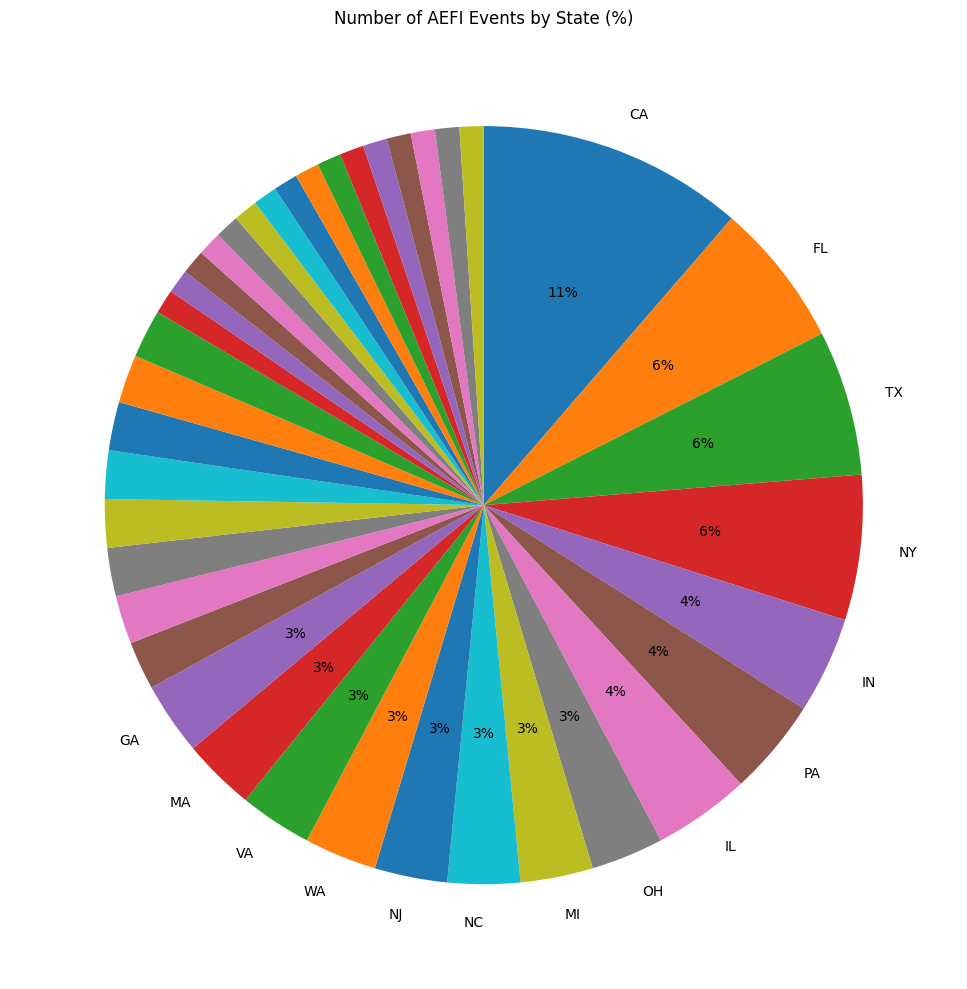

In [11]:
state_counts = (df['STATE']
                .dropna()
                .replace({'': np.nan})
                .dropna())
state_pct = (state_counts.value_counts(normalize=True) * 100).round(0)

plt.figure(figsize=(10,10))

labels = [s if p >= 3 else '' for s, p in state_pct.items()]
plt.pie(state_pct.values,
        labels=labels,
        autopct=lambda p: f"{p:.0f}%" if p >=3 else '',
        startangle=90,
        counterclock=False)
plt.title("Number of AEFI Events by State (%)")
plt.tight_layout()
plt.show()

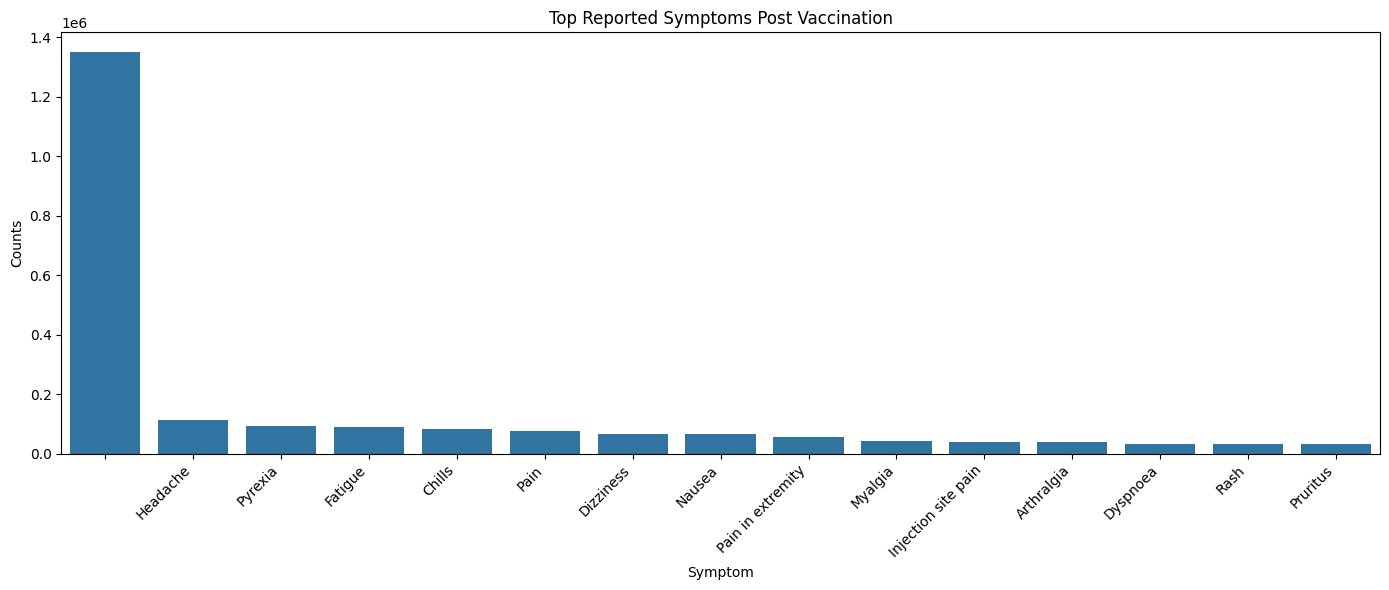

In [12]:
symptom_cols = [c for c in df.columns if re.fullmatch(r'SYMPTOM[1-5]', c)]
symptom_series = (df[symptom_cols]
                  .astype(str)
                  .stack()
                  .str.strip()
                  .replace({'nan':'', 'None':'', '':np.nan})
                  .dropna())

top_n = 15
top_symptoms = symptom_series.value_counts().head(top_n)

plt.figure(figsize=(14,6))
sns.barplot(x=top_symptoms.index, y=top_symptoms.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Counts")
plt.xlabel("Symptom")
plt.title("Top Reported Symptoms Post Vaccination")
plt.tight_layout()
plt.show()

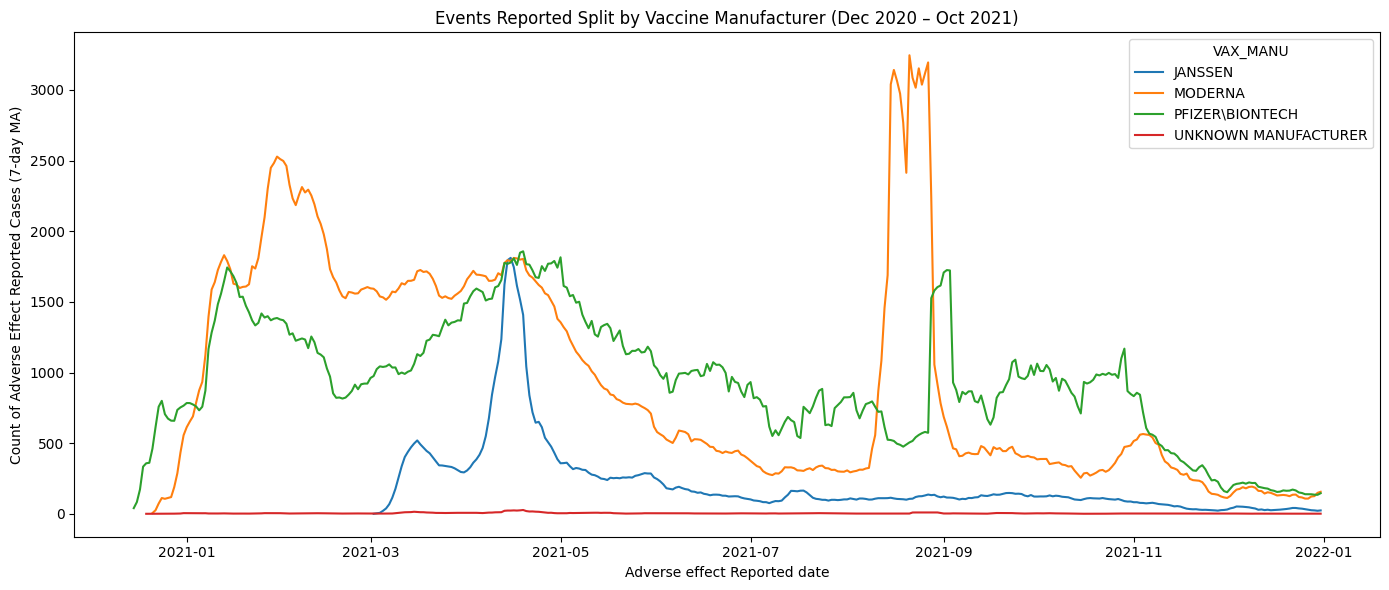

In [13]:
daily_manu = (df
              .dropna(subset=['RECVDATE','VAX_MANU'])
              .groupby([pd.Grouper(key='RECVDATE', freq='D'),
                        'VAX_MANU'])
              .size()
              .reset_index(name='count'))

major_manu = ['PFIZER\\BIONTECH','MODERNA','JANSSEN']
daily_manu['VAX_MANU_CLEAN'] = np.where(
    daily_manu['VAX_MANU'].str.upper().isin(major_manu),
    daily_manu['VAX_MANU'].str.upper(),
    'UNKNOWN MANUFACTURER'
)

plot_df = (daily_manu
           .groupby(['RECVDATE','VAX_MANU_CLEAN'])['count']
           .sum()
           .reset_index())

plot_df['count_smooth'] = (plot_df
                           .groupby('VAX_MANU_CLEAN')['count']
                           .transform(lambda s: s.rolling(7, min_periods=1).mean()))

plt.figure(figsize=(14,6))
for manu, g in plot_df.groupby('VAX_MANU_CLEAN'):
    plt.plot(g['RECVDATE'], g['count_smooth'], label=manu)
plt.legend(title='VAX_MANU')
plt.xlabel("Adverse effect Reported date")
plt.ylabel("Count of Adverse Effect Reported Cases (7‑day MA)")
plt.title("Events Reported Split by Vaccine Manufacturer (Dec 2020 – Oct 2021)")
plt.tight_layout()
plt.show()

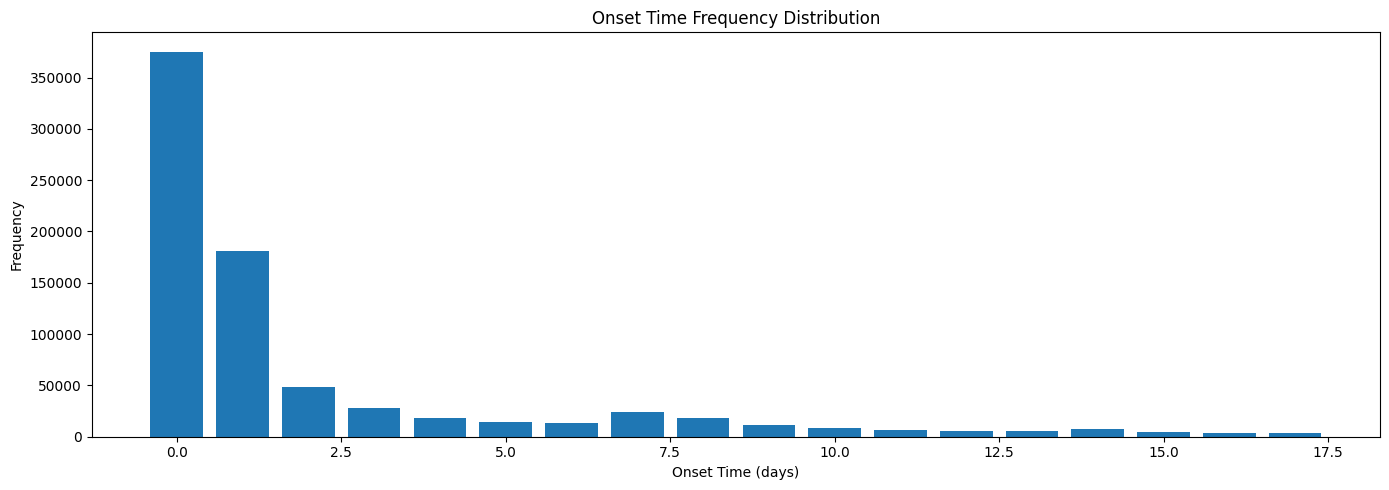

In [14]:
numdays_window = df[(df['NUMDAYS'] >= 0) & (df['NUMDAYS'] <= 50)]
counts_numdays = numdays_window['NUMDAYS'].value_counts().sort_index()

plt.figure(figsize=(14,5))
plt.bar(counts_numdays.index, counts_numdays.values)
plt.xlabel("Onset Time (days)")
plt.ylabel("Frequency")
plt.title("Onset Time Frequency Distribution")
plt.tight_layout()
plt.show()

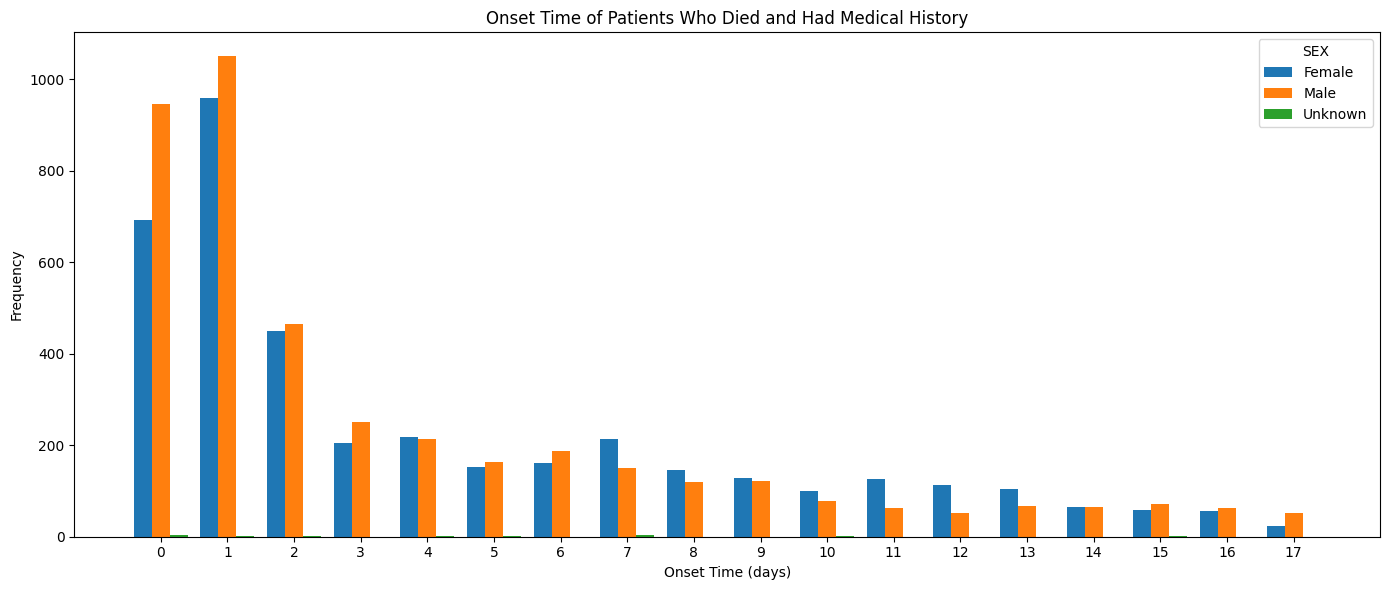

In [15]:
died_hist = df[(df['DIED'] == 'Y') &
               (df['HISTORY'].notna()) &
               (df['NUMDAYS'] >= 0) &
               (df['NUMDAYS'] <= 50)]


died_hist['SEX_N'] = died_hist['SEX'].replace({'M':'M','F':'F'}).fillna('U')


onset_sex_counts = (died_hist
                    .groupby(['NUMDAYS','SEX_N'])
                    .size()
                    .reset_index(name='freq'))

pivot_onset = onset_sex_counts.pivot(index='NUMDAYS', columns='SEX_N', values='freq').fillna(0)

plt.figure(figsize=(14,6))
bar_width = 0.27
xs = np.arange(len(pivot_onset.index))
for i, sex in enumerate(pivot_onset.columns):
    plt.bar(xs + i*bar_width,
            pivot_onset[sex].values,
            width=bar_width,
            label=sex)
plt.xticks(xs + bar_width, pivot_onset.index, rotation=0)
plt.xlabel("Onset Time (days)")
plt.ylabel("Frequency")
plt.title("Onset Time of Patients Who Died and Had Medical History")
plt.legend(title='SEX')
plt.tight_layout()
plt.show()

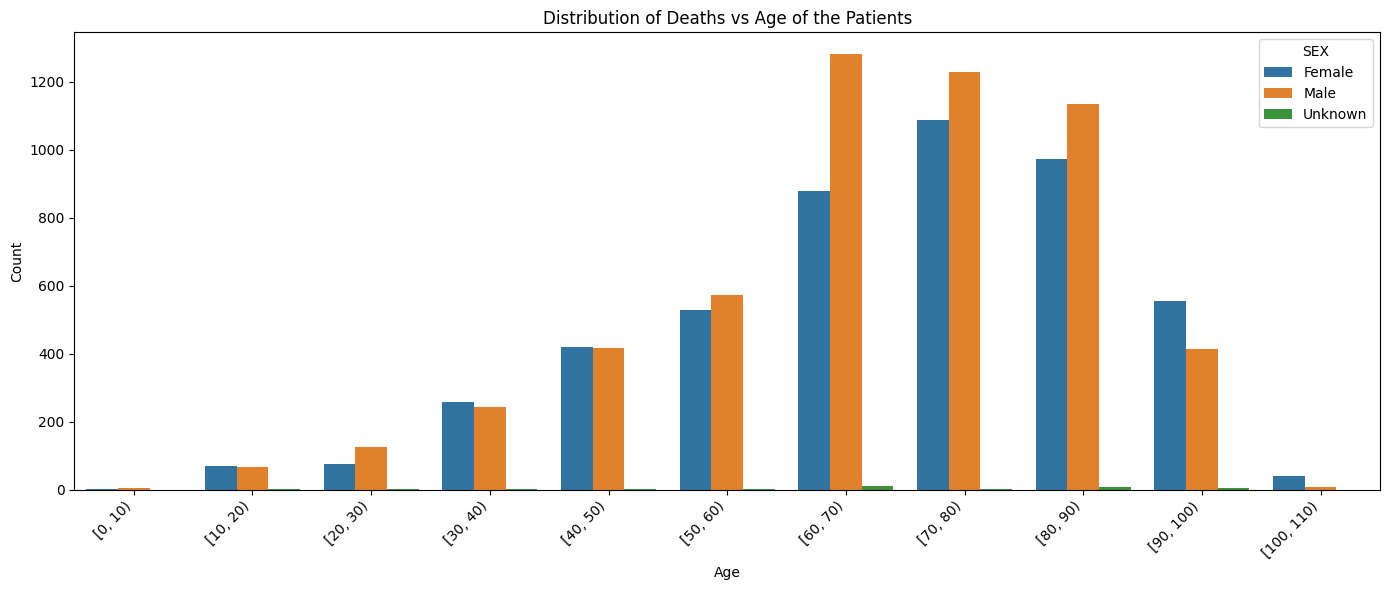

In [16]:
deaths = df[(df['DIED'] == 'Y') & df['AGE_YRS'].notna() & (df['AGE_YRS'] >= 0)]


bins = list(range(0, 111, 10))
deaths['AGE_BIN'] = pd.cut(deaths['AGE_YRS'], bins=bins, right=False)

age_sex_counts = (deaths
                  .groupby(['AGE_BIN','SEX'])
                  .size()
                  .reset_index(name='count'))

plt.figure(figsize=(14,6))
sns.barplot(data=age_sex_counts,
            x='AGE_BIN', y='count', hue='SEX')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Deaths vs Age of the Patients")
plt.tight_layout()
plt.show()

## 5. Feature engineering for Onset‑Time Regression

In [17]:
df_model = df

In [18]:
df_model['SEX'] = df_model['SEX'].replace(
    {'Male':'M','Female':'F','M':'M','F':'F'}
)


manu_cols = [c for c in df_model.columns if c.startswith('MANU_')]

manu_known_cols = [c for c in manu_cols if 'UNK' not in c.upper() and 'UNKNOWN' not in c.upper()]

major_keywords = ['PFIZER', 'MODERNA', 'JANSSEN']
major_manu_cols = [c for c in manu_known_cols if any(k in c.upper() for k in major_keywords)]


comorb_cols = [c for c in df_model.columns if c.startswith('CM_')]


flag_cols = []
for col in ['HAS_OTHER_MEDS', 'HAS_CUR_ILL', 'HAS_DISABILITY']:
    if col in df_model.columns:
        flag_cols.append(col)


df_model['SEX_F'] = (df_model['SEX'] == 'F').astype(int)


feature_cols = ['AGE_YRS', 'SEX_F'] + major_manu_cols + comorb_cols + flag_cols


In [19]:
mask_age   = df_model['AGE_YRS'] >= 11
mask_sex   = df_model['SEX'].isin(['M','F'])
mask_manuf = df_model[major_manu_cols].sum(axis=1) > 0
df_model = df_model[mask_age & mask_sex & mask_manuf].copy()


df_model = df_model.dropna(subset=feature_cols + ['NUMDAYS'])

print("Modeling rows:", df_model.shape[0])
print("Features used:", feature_cols)

Modeling rows: 744529
Features used: ['AGE_YRS', 'SEX_F', 'MANU_JANSSEN', 'MANU_MODERNA', 'MANU_PFIZER\\BIONTECH', 'CM_ASTHMA', 'CM_DIABETES', 'CM_HYPERTENSION', 'CM_OBESITY', 'CM_CARDIO', 'CM_RENAL_DISEASE', 'CM_COPD', 'CM_CANCER', 'CM_LIVER_DISEASE', 'CM_IMMUNODEF', 'CM_NEURO', 'CM_AUTOIMMUNE', 'CM_THYROID', 'CM_ANXIETY', 'CM_PREGNANCY', 'CM_SMOKER', 'CM_ALLERGY', 'HAS_OTHER_MEDS', 'HAS_CUR_ILL', 'HAS_DISABILITY']


In [20]:
X = df_model[feature_cols].astype(float)
y = df_model['NUMDAYS'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

results = []

In [21]:
ols = LinearRegression()
ols.fit(X_train, y_train)
results.append({
    'Model': 'OLS',
    'Train_RMSE': rmse(y_train, ols.predict(X_train)),
    'Test_RMSE': rmse(y_test, ols.predict(X_test)),
    'Estimator': ols
})

In [22]:
lasso = LassoCV(
    alphas=None,
    cv=10,
    random_state=42,
    max_iter=10000,
    n_jobs=-1
)
lasso.fit(X_train, y_train)
results.append({
    'Model': 'Lasso',
    'Train_RMSE': rmse(y_train, lasso.predict(X_train)),
    'Test_RMSE': rmse(y_test, lasso.predict(X_test)),
    'Estimator': lasso
})

In [23]:
ridge_alphas = np.logspace(-3, 3, 30)
ridge = RidgeCV(alphas=ridge_alphas, cv=10, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
results.append({
    'Model': 'Ridge',
    'Train_RMSE': rmse(y_train, ridge.predict(X_train)),
    'Test_RMSE': rmse(y_test, ridge.predict(X_test)),
    'Estimator': ridge
})

In [24]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
results.append({
    'Model': 'XGBoost',
    'Train_RMSE': rmse(y_train, xgb.predict(X_train)),
    'Test_RMSE': rmse(y_test, xgb.predict(X_test)),
    'Estimator': xgb
})


In [25]:
mlp = MLPRegressor(
    hidden_layer_sizes=(300,),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1
)
mlp.fit(X_train, y_train)
results.append({
    'Model': 'MLP Regressor',
    'Train_RMSE': rmse(y_train, mlp.predict(X_train)),
    'Test_RMSE': rmse(y_test, mlp.predict(X_test)),
    'Estimator': mlp
})

In [26]:
n_feat = X_train.shape[1]
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=100,
    max_features=max(1, n_feat // 3),
    n_jobs=-1,
    random_state=42,
    oob_score=False
)
rf.fit(X_train, y_train)
results.append({
    'Model': 'Random Forest',
    'Train_RMSE': rmse(y_train, rf.predict(X_train)),
    'Test_RMSE': rmse(y_test, rf.predict(X_test)),
    'Estimator': rf
})

In [27]:
res_df = (pd.DataFrame(results)
          .assign(Train_RMSE=lambda d: d['Train_RMSE'].round(2),
                  Test_RMSE=lambda d: d['Test_RMSE'].round(2))
          .loc[:, ['Model', 'Train_RMSE', 'Test_RMSE', 'Estimator']])

print("\nPerformance (RMSE):")
display(res_df[['Model','Train_RMSE','Test_RMSE']])


Performance (RMSE):


,Model,Train_RMSE,Test_RMSE
0,OLS,3.43,3.41
1,Lasso,3.44,3.42
2,Ridge,3.43,3.41
3,XGBoost,3.37,3.37
4,MLP Regressor,3.40,3.39
5,Random Forest,3.18,3.32


In [28]:
def top_coefficients(estimator, feature_names, k=5):
    """Return top k features by absolute value of coefficient for linear models."""
    coefs = estimator.coef_
    abs_coefs = np.abs(coefs)
    idx = np.argsort(-abs_coefs)[:k]
    return [feature_names[i] for i in idx]

def map_display_name(feat):
    if feat.startswith('CM_'):
        return feat[3:].lower()
    if feat.startswith('MANU_'):
        return feat.replace('MANU_','VAX_MANU_').upper()
    if feat == 'SEX_F':
        return 'SEX_F'
    if feat in ['HAS_OTHER_MEDS','HAS_CUR_ILL','HAS_DISABILITY']:
        return feat.lower()
    return feat.lower()


top_list = []
for _, row in res_df.iterrows():
    est = row['Estimator']
    if isinstance(est, (LinearRegression, LassoCV, RidgeCV)):
        tops = top_coefficients(est, X_train.columns, k=5)
        top_list.append(", ".join(map(map_display_name, tops)))
    elif isinstance(est, RandomForestRegressor):
        imp = est.feature_importances_
        tops = np.argsort(-imp)[:5]
        top_list.append(", ".join(map(map_display_name, X_train.columns[tops])))
    elif isinstance(est, XGBRegressor):
        imp = est.feature_importances_
        tops = np.argsort(-imp)[:5]
        top_list.append(", ".join(map(map_display_name, X_train.columns[tops])))
    elif isinstance(est, MLPRegressor):
        top_list.append("—")
    else:
        top_list.append("")

res_df['Top Predictors'] = top_list


table1 = res_df[['Model','Train_RMSE','Test_RMSE','Top Predictors']].copy()
display(table1)

,Model,Train_RMSE,Test_RMSE,Top Predictors
0,OLS,3.43,3.41,"has_disability, smoker, has_other_meds, obesit..."
1,Lasso,3.44,3.42,"has_disability, has_other_meds, VAX_MANU_PFIZE..."
2,Ridge,3.43,3.41,"has_disability, smoker, has_other_meds, obesit..."
3,XGBoost,3.37,3.37,"has_disability, has_other_meds, VAX_MANU_PFIZE..."
4,MLP Regressor,3.40,3.39,—
5,Random Forest,3.18,3.32,"age_yrs, has_other_meds, has_disability, has_c..."


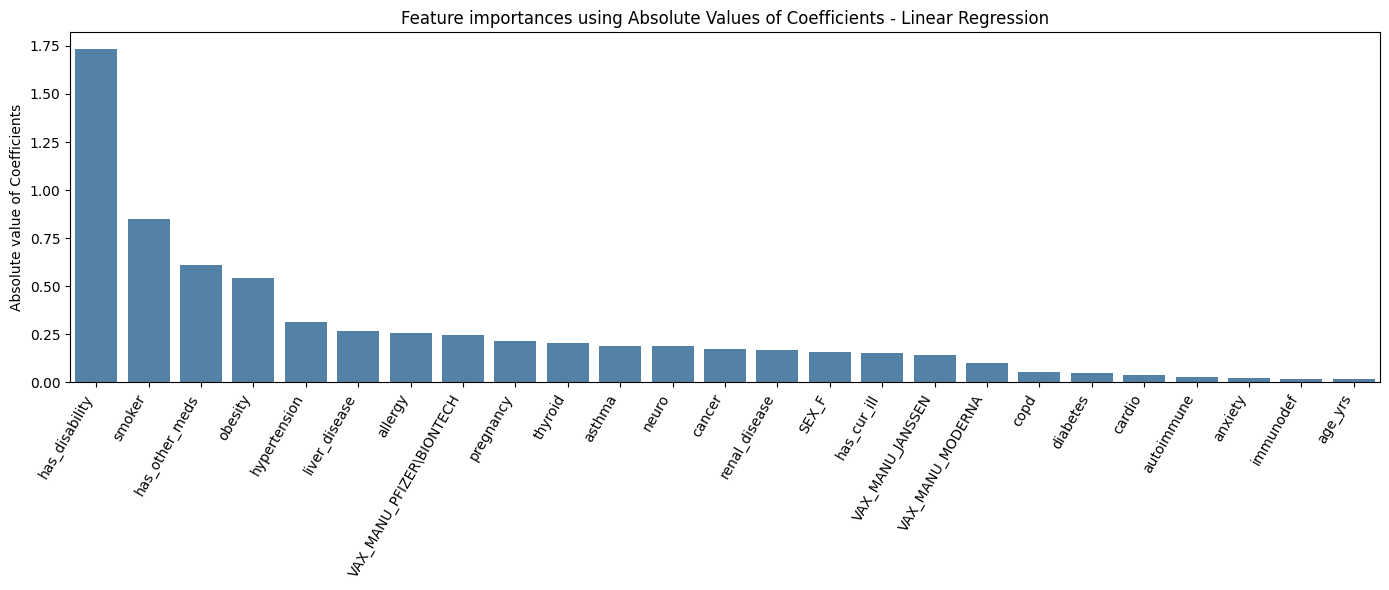

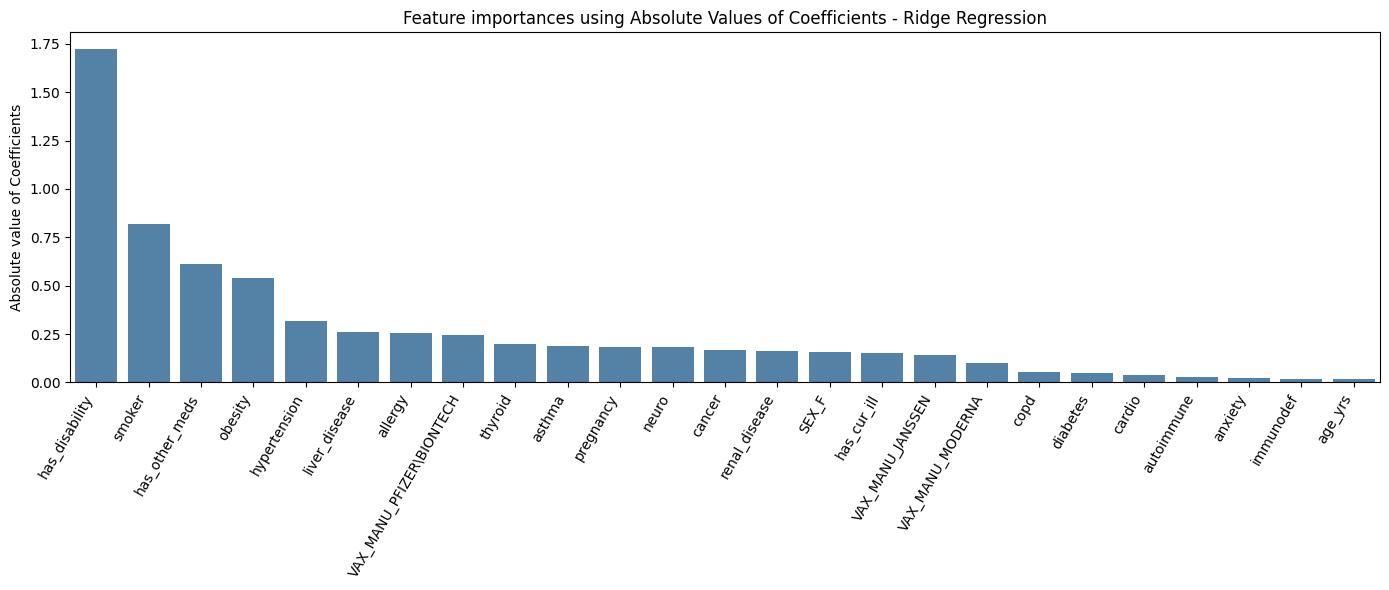

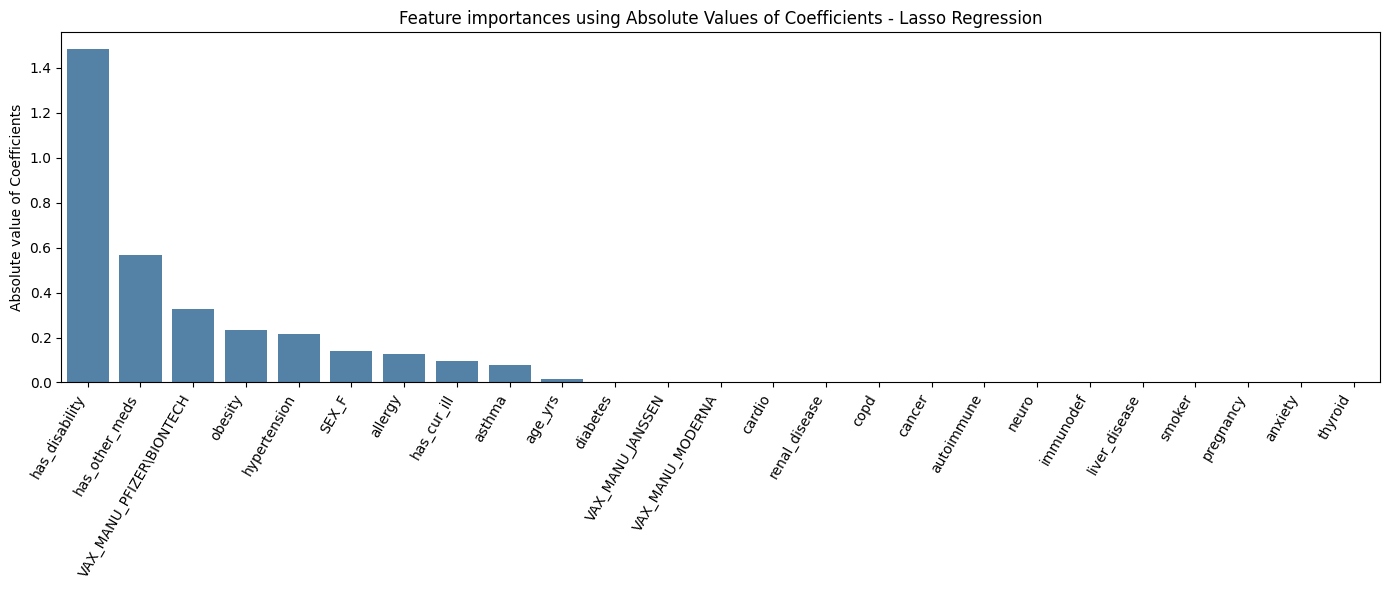

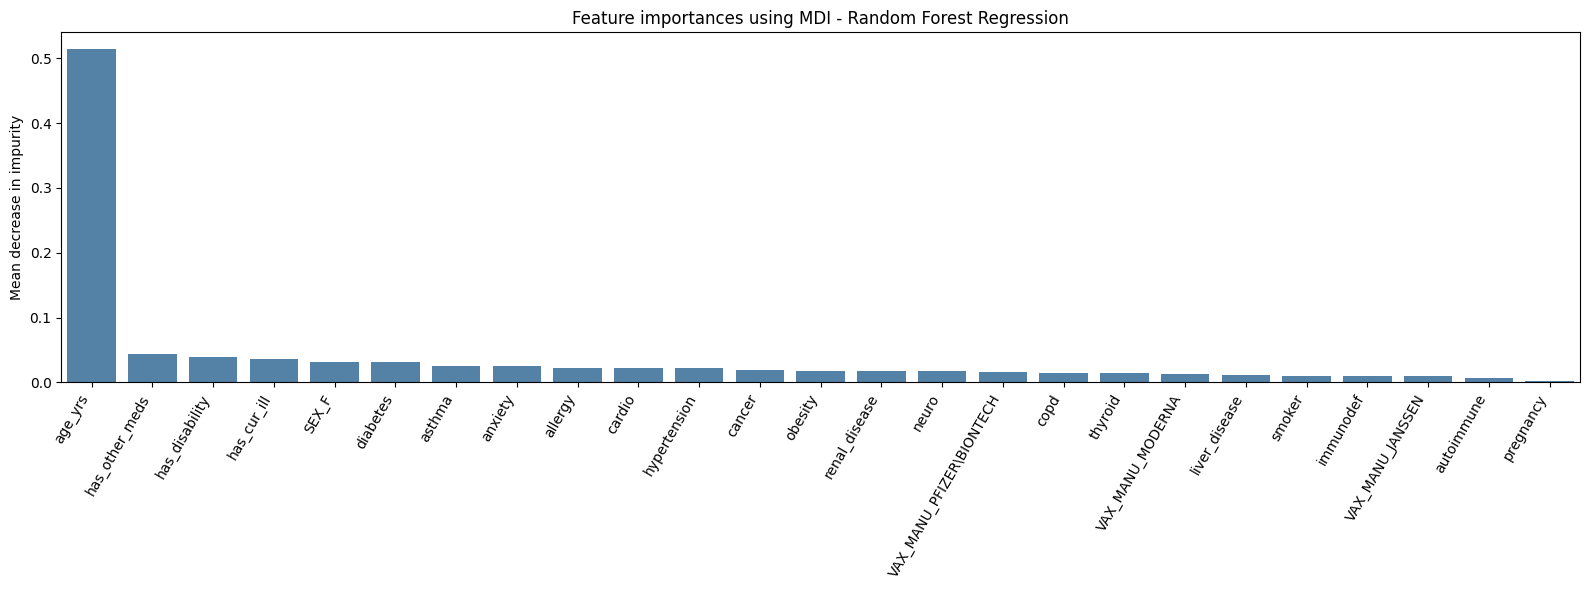

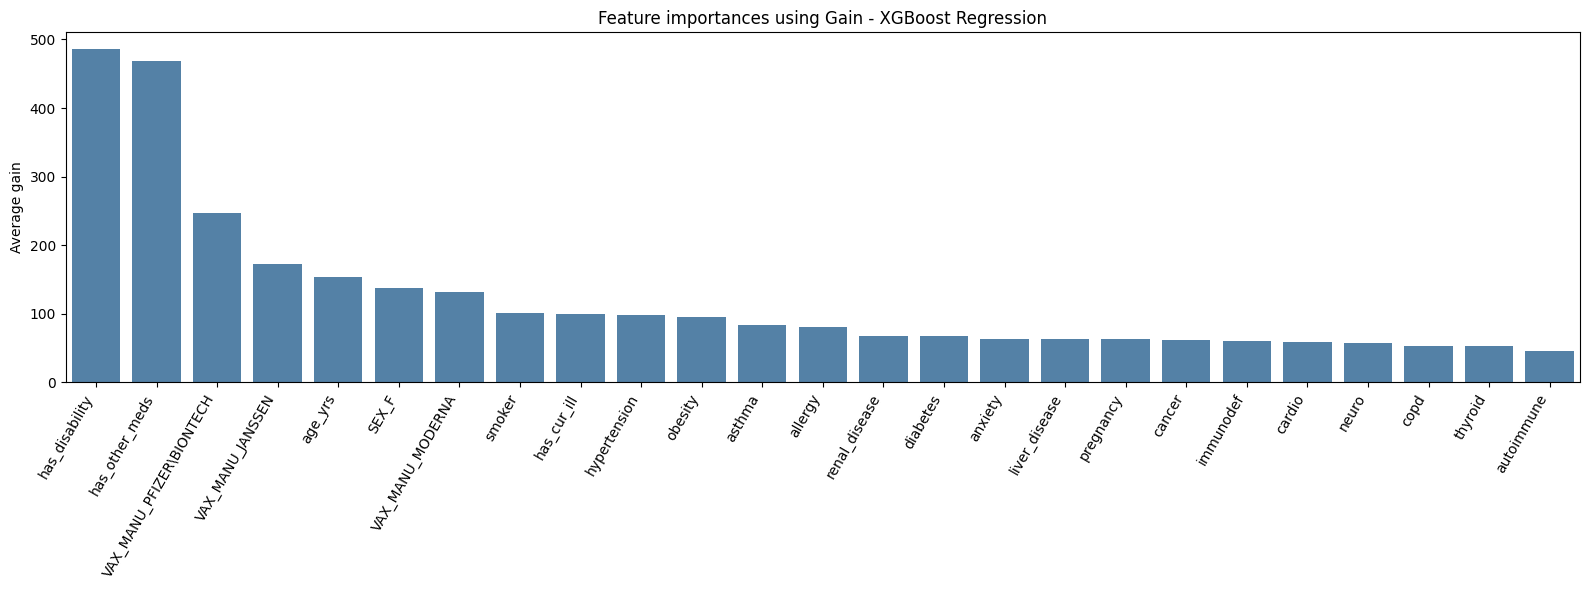

In [29]:
def plot_linear_coeffs(estimator, title, top_n=25):
    coefs = estimator.coef_
    df_plot = (pd.DataFrame({
        'feature': X_train.columns,
        'abs_coef': np.abs(coefs),
        'coef': coefs
    })
    .sort_values('abs_coef', ascending=False)
    .head(top_n))
    df_plot['display'] = df_plot['feature'].map(map_display_name)
    plt.figure(figsize=(14,6))
    sns.barplot(data=df_plot, x='display', y='abs_coef', color='steelblue')
    plt.xticks(rotation=60, ha='right')
    plt.ylabel("Absolute value of Coefficients")
    plt.xlabel("")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_linear_coeffs(ols,   "Feature importances using Absolute Values of Coefficients - Linear Regression")
plot_linear_coeffs(ridge, "Feature importances using Absolute Values of Coefficients - Ridge Regression")
plot_linear_coeffs(lasso, "Feature importances using Absolute Values of Coefficients - Lasso Regression")


rf_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,6))
sns.barplot(data=rf_importances.head(30),
            x=rf_importances.head(30)['feature'].map(map_display_name),
            y='importance',
            color='steelblue')
plt.xticks(rotation=60, ha='right')
plt.ylabel("Mean decrease in impurity")
plt.xlabel("")
plt.title("Feature importances using MDI - Random Forest Regression")
plt.tight_layout()
plt.show()


booster = xgb.get_booster()
score_gain = booster.get_score(importance_type='gain')

gain_list = []
for f in X_train.columns:
    pass


internal_map = {f"f{idx}": col for idx, col in enumerate(X_train.columns)}
gain_df = (pd.DataFrame([
    {'feature': internal_map.get(k, k), 'gain': v}
    for k, v in score_gain.items()
])
.assign(gain=lambda d: d['gain'].astype(float))
.sort_values('gain', ascending=False))

plt.figure(figsize=(16,6))
sns.barplot(data=gain_df.head(30),
            x=gain_df.head(30)['feature'].map(map_display_name),
            y='gain',
            color='steelblue')
plt.xticks(rotation=60, ha='right')
plt.ylabel("Average gain")
plt.xlabel("")
plt.title("Feature importances using Gain - XGBoost Regression")
plt.tight_layout()
plt.show()


table1_out = table1
table1_out.to_csv("table1_onset_time_regression_results.csv", index=False)

## 6. Train/Test split

In [9]:
work_df = df

RANDOM_STATE          = 42
TRAIN_TEST_SPLIT      = 0.20
SPARSITY_LEVEL        = 25
SPARSE_PCA_COMPONENTS = 25
SPARSE_PCA_ALPHA      = 0.0005
SVD_COMPONENTS        = 50

UNDERSAMPLE_RATIO     = 1.0
SMOTE_K_NEIGHBORS     = 5
MIN_SYMPTOM_COUNT     = 1

In [10]:
symptom_cols = [c for c in work_df.columns if c.upper().startswith('SYMPTOM')]

def collect_flat(group_df):

    raw = group_df[symptom_cols].values.tolist()
    flat = list(chain.from_iterable(raw))
    cleaned = [str(x).strip() for x in flat if pd.notna(x) and str(x).strip() not in ('', 'nan', 'None')]
    return cleaned

symptom_lists = (work_df
                 .groupby('VAERS_ID', sort=False)
                 .apply(collect_flat))


counts = Counter(chain.from_iterable(symptom_lists))
keep_symptoms = {s for s,c in counts.items() if c >= MIN_SYMPTOM_COUNT}

symptom_lists_filtered = symptom_lists.apply(lambda lst: [s for s in lst if s in keep_symptoms])

mlb = MultiLabelBinarizer(sparse_output=True)
X_symptoms_sparse = mlb.fit_transform(symptom_lists_filtered)

print("Symptom matrix shape:", X_symptoms_sparse.shape)


Symptom matrix shape: (528212, 516286)


In [11]:
hospital_series = (work_df[['VAERS_ID','HOSPITAL']]
                   .drop_duplicates('VAERS_ID')
                   .set_index('VAERS_ID')
                   .loc[symptom_lists.index])

y = (hospital_series['HOSPITAL'] == 'Y').astype(int).values


valid_mask = ~pd.isna(y)
X_symptoms_sparse = X_symptoms_sparse[valid_mask]
y = y[valid_mask]

print("Label distribution BEFORE balancing:", np.bincount(y))

Label distribution BEFORE balancing: [506416  21796]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_symptoms_sparse, y,
    test_size=TRAIN_TEST_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y
)

In [13]:
rus = RandomUnderSampler(sampling_strategy=UNDERSAMPLE_RATIO,
                         random_state=RANDOM_STATE)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

smote = SMOTE(k_neighbors=SMOTE_K_NEIGHBORS,
              random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_us, y_train_us)

print("Label distribution AFTER balancing:", np.bincount(y_train_bal))


def compute_metrics(model, X_tr, y_tr, X_te, y_te, name):

    if hasattr(model, "predict_proba"):
        tr_scores = model.predict_proba(X_tr)[:,1]
        te_scores = model.predict_proba(X_te)[:,1]
    elif hasattr(model, "decision_function"):
        tr_scores = model.decision_function(X_tr)
        te_scores = model.decision_function(X_te)
    else:
        tr_scores = model.predict(X_tr)
        te_scores = model.predict(X_te)

    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    def spec_sens(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn+fp) else 0
        sensitivity = tp / (tp + fn) if (tp+fn) else 0
        return specificity, sensitivity

    tr_spec, tr_sens = spec_sens(y_tr, y_tr_pred)
    te_spec, te_sens = spec_sens(y_te, y_te_pred)

    tr_auc = roc_auc_score(y_tr, tr_scores) if len(np.unique(y_tr)) == 2 else np.nan
    te_auc = roc_auc_score(y_te, te_scores) if len(np.unique(y_te)) == 2 else np.nan

    return {
        'Metric': name,
        'Train Specificity': round(tr_spec, 2),
        'Train Sensitivity': round(tr_sens, 2),
        'ROC-AUC Score': round(te_auc, 2),
        'Test Specificity': round(te_spec, 2),
        'Test Sensitivity': round(te_sens, 2)
    }


def run_models(Xtr, ytr, Xte, yte):
    results = []
    models = {}

    # Logistic Regression
    logreg = LogisticRegression(
        penalty='l2',
        max_iter=1000,
        class_weight=None,
        solver='liblinear',
        random_state=RANDOM_STATE
    )
    logreg.fit(Xtr, ytr)
    results.append(compute_metrics(logreg, Xtr, ytr, Xte, yte, 'Logistic Regression'))
    models['Logistic Regression'] = logreg

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=100,
        max_features=max(1, (Xtr.shape[1] // 3)),
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    rf.fit(Xtr, ytr)
    results.append(compute_metrics(rf, Xtr, ytr, Xte, yte, 'Random Forest'))
    models['Random Forest'] = rf

    # Linear SVM
    lsvm = LinearSVC(
        C=1.0,
        max_iter=5000,
        random_state=RANDOM_STATE
    )
    lsvm.fit(Xtr, ytr)
    results.append(compute_metrics(lsvm, Xtr, ytr, Xte, yte, 'Linear SVM'))
    models['Linear SVM'] = lsvm

    # XGBoost Classifier
    xgbc = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgbc.fit(Xtr, ytr)
    results.append(compute_metrics(xgbc, Xtr, ytr, Xte, yte, 'XGBoostClassifier'))
    models['XGBoostClassifier'] = xgbc

    return pd.DataFrame(results).set_index('Metric'), models

Label distribution AFTER balancing: [17437 17437]


In [38]:
def sparse_naive_bayes_feature_select(X, y, top_k):
    X = X.tocsc()
    n_samples, n_features = X.shape
    y = np.asarray(y)

    pos_idx = (y == 1)
    neg_idx = ~pos_idx

    alpha = 1.0
    pos_counts = X[pos_idx].sum(axis=0).A1 + alpha
    neg_counts = X[neg_idx].sum(axis=0).A1 + alpha
    pos_total = pos_idx.sum() + 2*alpha
    neg_total = neg_idx.sum() + 2*alpha

    p_pos = pos_counts / pos_total
    p_neg = neg_counts / neg_total

    epsilon = 1e-9
    log_odds_pos = np.log(p_pos + epsilon) - np.log(1 - p_pos + epsilon)
    log_odds_neg = np.log(p_neg + epsilon) - np.log(1 - p_neg + epsilon)
    importance = np.abs(log_odds_pos - log_odds_neg)

    top_indices = np.argsort(-importance)[:top_k]
    return top_indices, importance[top_indices]


top_idx, _ = sparse_naive_bayes_feature_select(X_train_bal, y_train_bal, SPARSITY_LEVEL)
X_train_nb = X_train_bal[:, top_idx]
X_test_nb  = X_test[:, top_idx]

results_nb, models_nb = run_models(X_train_nb, y_train_bal, X_test_nb, y_test)
results_nb.name = "Sparse Naive Bayes Feature Selection"
print("\n=== Sparse Naïve Bayes Feature Selection Results ===")
display(results_nb)


=== Sparse Naïve Bayes Feature Selection Results ===


,Train Specificity,Train Sensitivity,ROC-AUC Score,Test Specificity,Test Sensitivity
Metric,,,,,
Logistic Regression,1.0,0.34,0.68,1.0,0.35
Random Forest,1.0,0.34,0.68,1.0,0.35
Linear SVM,1.0,0.34,0.68,1.0,0.35
XGBoostClassifier,1.0,0.34,0.68,1.0,0.35


In [ ]:
pos_rows = (y_train_bal == 1)
X_pos = X_train_bal[pos_rows]

X_pos_dense = X_pos.toarray()

spca = SparsePCA(
    n_components=SPARSE_PCA_COMPONENTS,
    alpha=SPARSE_PCA_ALPHA,
    random_state=RANDOM_STATE,
    max_iter=1000,
    tol=1e-6,
    method='lars'
)
spca.fit(X_pos_dense)


X_train_spca = spca.transform(X_train_bal.toarray())
X_test_spca  = spca.transform(X_test.toarray())


scaler_spca = StandardScaler()
X_train_spca = scaler_spca.fit_transform(X_train_spca)
X_test_spca  = scaler_spca.transform(X_test_spca)

results_spca, models_spca = run_models(X_train_spca, y_train_bal, X_test_spca, y_test)
results_spca.name = "Sparse PCA"
print("\n=== Sparse PCA Results ===")
display(results_spca)

In [ ]:
svd = TruncatedSVD(
    n_components=SVD_COMPONENTS,
    random_state=RANDOM_STATE
)
svd.fit(X_train_bal)

X_train_svd = svd.transform(X_train_bal)
X_test_svd  = svd.transform(X_test)

scaler_svd = StandardScaler()
X_train_svd = scaler_svd.fit_transform(X_train_svd)
X_test_svd  = scaler_svd.transform(X_test_svd)

results_svd, models_svd = run_models(X_train_svd, y_train_bal, X_test_svd, y_test)
results_svd.name = "SVD"
print("\n=== SVD Results ===")
display(results_svd)

In [ ]:
def reshape_for_report(df, label):
    table = df[['Train Specificity','Train Sensitivity','ROC-AUC Score','Test Specificity','Test Sensitivity']].T
    table.columns = df.index
    table.insert(0, 'Metric', table.index)
    table.reset_index(drop=True, inplace=True)
    return label, table

sections = []
for label, df_sec in [
    ("Sparse Naïve Bayes Feature Selection", results_nb),
    ("Sparse PCA", results_spca),
    ("SVD", results_svd)
]:
    sections.append(reshape_for_report(df_sec, label))


for label, tbl in sections:
    print("\n" + label)
    display(tbl)

results_nb.to_csv("goal2_sparse_nb_results.csv")
results_spca.to_csv("goal2_sparse_pca_results.csv")
results_svd.to_csv("goal2_svd_results.csv")
print("\nSaved: goal2_sparse_nb_results.csv, goal2_sparse_pca_results.csv, goal2_svd_results.csv")

In [ ]:
symptom_feature_names = np.array(mlb.classes_)
top_symptom_names = symptom_feature_names[top_idx]
print("\nTop features (Sparse Naïve Bayes selection):")
print(top_symptom_names)